## GPU Configuration and Imports <a class="anchor" id="GPU-Configuration-and-Imports"></a>

In [2]:
import os # Configure which GPU 
gpu_num = 0 # Use "" to use the CPU
os.environ["CUDA_VISIBLE_DEVICES"] = f"{gpu_num}"
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'

# Colab does currently not support the latest version of ipython.
# Thus, the preview does not work in Colab. However, whenever possible we 
# strongly recommend to use the scene preview mode.
try: # detect if the notebook runs in Colab
    import google.colab
    colab_compat = True # deactivate preview
except:
    colab_compat = False
resolution = [480,320] # increase for higher quality of renderings

# Allows to exit cell execution in Jupyter
class ExitCell(Exception):
    def _render_traceback_(self):
        pass

# Import Sionna
try:
    import sionna
except ImportError as e:
    # Install Sionna if package is not already installed
    import os
    os.system("pip install sionna")
    import sionna

# Configure the notebook to use only a single GPU and allocate only as much memory as needed
# For more details, see https://www.tensorflow.org/guide/gpu
import tensorflow as tf
gpus = tf.config.list_physical_devices('GPU')
if gpus:
    try:
        tf.config.experimental.set_memory_growth(gpus[0], True)
    except RuntimeError as e:
        print(e) 
# Avoid warnings from TensorFlow
tf.get_logger().setLevel('ERROR')

tf.random.set_seed(1) # Set global random seed for reproducibility
            
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import sys
    
from sionna.channel import cir_to_time_channel
from sionna.rt import load_scene, PlanarArray, Transmitter, Receiver, RadioMaterial, Camera, LambertianPattern, DirectivePattern, BackscatteringPattern
from sionna.rt.utils import r_hat
from sionna.constants import PI, SPEED_OF_LIGHT
from sionna.utils import expand_to_rank

from PIL import Image
from IPython.display import display
import time
import csv

In [3]:
# scene_path=sionna.rt.scene.simple_street_canyon
# scene_path="my_scene/nycu_test/nycu_test.xml"
scene_path="my_scene/nycu_test_v2/nycu_test_v2.xml"
# scene_path="my_scene/testv2/testv2.xml"
scene = load_scene(scene_path)

for i, obj in enumerate(scene.objects.values()):
    # print(f"{obj.name} : {obj.radio_material.name}")
    # print(scene.get(obj.name).radio_material.conductivity)
    # print(scene.get(obj.name).radio_material.relative_permittivity)
    # if "Plane" in obj.name:
    #     print("=============================================================")
    #     print(scene.get(obj.name).radio_material.conductivity)
    #     print(scene.get(obj.name).radio_material.relative_permittivity)
    # # print(f"{obj.name}")
    pass
# Open 3D preview (only works in Jupyter notebook)
# Add a camera for visualization
# scene.remove("my_cam")
# scene.add(Camera("my_cam", position=[0, 0, 100], look_at=[0,0,0]))
# scene.render(camera="my_cam", num_samples=512);
# render_to_file=True
# if render_to_file:
#     filename="image/test_my_cam.png"
#     scene.render_to_file(camera="my_cam", # Also try camera="preview"
#                          filename=filename,
#                          resolution=[800,800]
#                         )
#     img = Image.open(filename)
#     display(img)
scene.remove("tx")
tx_position=[-55,400,5]
scene.add(Transmitter(name="tx", position=tx_position))
scene.preview()


Renderer(camera=PerspectiveCamera(aspect=1.31, children=(DirectionalLight(intensity=0.25, position=(0.0, 0.0, …

In [4]:
print(scene.get("Plane").radio_material.conductivity)
water_material = RadioMaterial("my_material",
                                relative_permittivity=80.2,
                                conductivity=0.3,
                                scattering_pattern=LambertianPattern())
for i, obj in enumerate(scene.objects.values()):
    if "water" in obj.radio_material.name:
        scene.get(obj.name).radio_material=water_material
        # print("=============================================================")
    else:
        scene.get(obj.name).radio_material=scene.get("Plane").radio_material
    # print(f"{obj.name} : {obj.radio_material.name}")
    # print(scene.get(obj.name).radio_material.conductivity)

tf.Tensor(0.123086944, shape=(), dtype=float32)


used time of computing paths: 1.1501950610000051s
used time of coverage map: 4.8472224289999986s


Renderer(camera=PerspectiveCamera(aspect=1.31, children=(DirectionalLight(intensity=0.25, matrixWorldNeedsUpda…

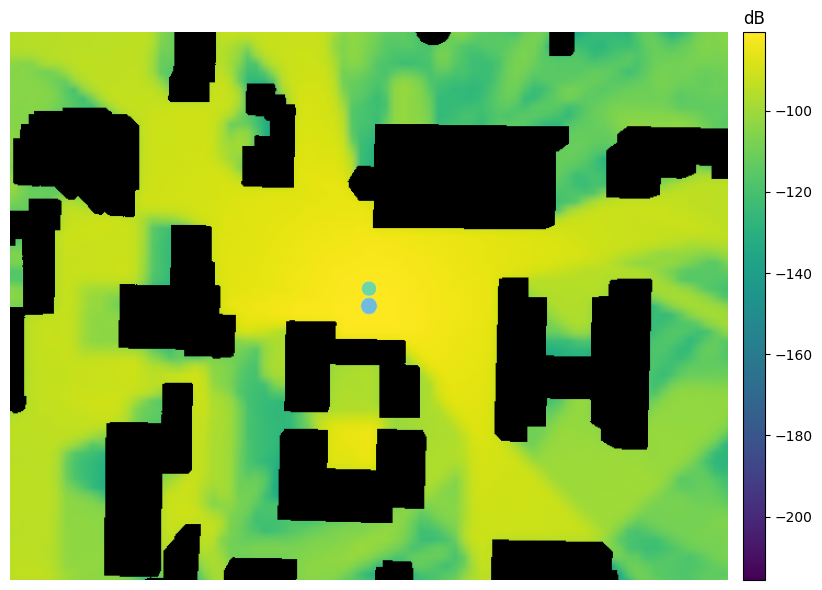

In [8]:
# scene_path="my_scene/nycu_test/nycu_test.xml"
# scene = load_scene(scene_path)
scene.remove("my_cam")
scene.remove("tx")
scene.remove("rx")
# Set the carrier frequency
scene.frequency = 5.8e9
wavelength = scene.wavelength


scene.add(Camera("my_cam", position=[0, 0, 500], look_at=[0,0,0]))
# Configure the transmitter and receiver arrays
scene.tx_array = PlanarArray(num_rows=1,
                             num_cols=1,
                             vertical_spacing=0.5,
                             horizontal_spacing=0.5,
                             pattern="iso",
                             polarization="V")

scene.rx_array = scene.tx_array

tx_position=[0,0,50]
scene.add(Transmitter(name="tx", position=tx_position))
tx_position=np.array(tx_position)

rx_position=[10, 0, 1]
scene.add(Receiver(name="rx", position=rx_position))

t_start = time.perf_counter()
paths = scene.compute_paths(los=True, reflection=True, scattering=True, scat_keep_prob=0.001)
t_end = time.perf_counter()
print(f"used time of computing paths: {t_end-t_start}s")

# Open 3D preview (only works in Jupyter notebook)
t_start = time.perf_counter()
cm = scene.coverage_map(max_depth=5,
                        diffraction=True, # Disable to see the effects of diffraction
                        cm_cell_size=(5., 5.), # Grid size of coverage map cells in m
                        combining_vec=None,
                        precoding_vec=None,
                        num_samples=int(20e6)) # Reduce if your hardware does not have enough memory
t_end = time.perf_counter()
print(f"used time of coverage map: {t_end-t_start}s")
render_to_file=False
# scene.render("my_cam",num_samples=512 , paths=paths , coverage_map=cm);
scene.render(camera="my_cam",num_samples=512 , coverage_map=cm);
if render_to_file:
    filename="image/test.png"
    scene.render_to_file(camera="my_cam", # Also try camera="preview"
                         filename=filename,
                         paths=paths,
                         # coverage_map=cm
                         )
    img = Image.open(filename)
    display(img)

# scene.preview(paths=paths, coverage_map=cm)
scene.preview( coverage_map=cm, paths=paths)

In [6]:
# paths.a

In [9]:
tx_position_dict={}
tx_position_dict["Base_Station_A"]=np.array([-150,-330,35])
tx_position_dict["Base_Station_A"]=np.array([-150,-330,35])
tx_position_dict["Base_Station_A"]=np.array([0,-275,40])
tx_position_dict["Base_Station_A"]=np.array([-150,50,35])
tx_position_dict["Base_Station_A"]=np.array([-55,400,5])
rx_positions=cm.sample_positions(5000)

In [12]:
scene.remove("tx")
scene.remove("rx")
scene.remove("my_cam")
# Set the carrier frequency
scene.frequency = 2.65e9
wavelength = scene.wavelength

csv_file_name="dataset.csv"
first_row=["Base_station_ID", "Tx_x", "Tx_y", "Tx_z", "Rx_x", "Rx_y", "Rx_z", "Distance", "Frequency", "LOS_Flag", "Received_power"]
with open(csv_file_name, 'w', newline='') as csv_file:
    csv_writer = csv.writer(csv_file)
    csv_writer.writerow(first_row)

# scene.add(Camera("my_cam", position=[0, 0, 500], look_at=[0,0,0]))
# Configure the transmitter and receiver arrays
scene.tx_array = PlanarArray(num_rows=1,
                             num_cols=1,
                             vertical_spacing=0.5,
                             horizontal_spacing=0.5,
                             pattern="iso",
                             polarization="V")

scene.rx_array = scene.tx_array

for base_station in tx_position_dict:
    tx_position=tx_position_dict[base_station]
    scene.add(Transmitter(name="tx", position=tx_position))
    distances = np.linalg.norm(rx_positions - tx_position, axis=1)
    received_powers = np.zeros_like(np.array(distances), np.float32)
    for i, rx_position in enumerate(rx_positions):
        scene.add(Receiver(name="rx", position=rx_position))
        t_start = time.perf_counter()

        # check LOS
        temp_path1 = scene.compute_paths(los=False, reflection=False, scattering=False, scat_keep_prob=0.001)
        temp_path2 = scene.compute_paths(los=True, reflection=False, scattering=False, scat_keep_prob=0.001)
        LOS_flag=0
        if tf.size(temp_path1.a).numpy()!=tf.size(temp_path2.a).numpy():
            LOS_flag=1
        
        paths = scene.compute_paths(los=True, reflection=True, scattering=True, scat_keep_prob=0.001)
        
        t_end = time.perf_counter()
        print(f"used time of computing paths: {t_end-t_start}s, paths nums:{tf.size(paths.a).numpy()}")
        received_power=10*np.log10(tf.reduce_sum(tf.abs(paths.a)**2))
        received_powers[i] = received_power
        scene.remove("rx")
        # first_row=["Base_station_ID", "Tx_x", "Tx_y", "Tx_z", "Rx_x", "Rx_y", "Rx_z", "Distance", "Frequency", "LOS_Flag", "Received_power"]
        # data_to_write=[base_station, 
        #                str(tx_position[0]), str(tx_position[1]), str(tx_position[2]), 
        #                str(rx_position[0]), str(rx_position[1]), str(rx_position[2]),
        #                str(distances[i]), str(scene.frequency), str(LOS_flag), str(received_power) 
        #               ]
        data_to_write=[base_station, 
               tx_position[0], tx_position[1], tx_position[2], 
               rx_position[0].numpy(), rx_position[1].numpy(), rx_position[2].numpy(),
               distances[i], scene.frequency.numpy(), LOS_flag,received_power 
              ]
        with open(csv_file_name, 'a+', newline='') as csv_file:
            csv_writer = csv.writer(csv_file)
            csv_writer.writerow(data_to_write)

used time of computing paths: 1.1254565209999896s, paths nums:1


/tmp/ipykernel_3635/1017929127.py:45: RuntimeWarning: divide by zero encountered in log10
  received_power=10*np.log10(tf.reduce_sum(tf.abs(paths.a)**2))


used time of computing paths: 1.1208107560000258s, paths nums:40
used time of computing paths: 1.0367522930000064s, paths nums:0
used time of computing paths: 1.061640533000002s, paths nums:8
used time of computing paths: 1.2178352189999941s, paths nums:108
used time of computing paths: 1.0755183399999737s, paths nums:0
used time of computing paths: 1.1703906100000268s, paths nums:1
used time of computing paths: 1.1631853810000052s, paths nums:2
used time of computing paths: 1.0844618579999974s, paths nums:4
used time of computing paths: 1.0832385120000367s, paths nums:1
used time of computing paths: 1.0054956679999805s, paths nums:0
used time of computing paths: 1.0959433860000445s, paths nums:14
used time of computing paths: 1.0033333009999978s, paths nums:0
used time of computing paths: 1.0996950509999692s, paths nums:3
used time of computing paths: 1.1372853320000331s, paths nums:2
used time of computing paths: 1.1532670970000254s, paths nums:15
used time of computing paths: 1.0131

KeyboardInterrupt: 